In [19]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.initializers import RandomNormal  
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras import optimizers

In [20]:
batch_size    = 128
#epochs        = 164
epochs        = 5
iterations    = 391
num_classes   = 10
dropout       = 0.5
log_filepath  = './nin'

In [21]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]

    return x_train, x_test

In [22]:
def scheduler(epoch):
  learning_rate_init = 0.08
  if epoch >= 81:
    learning_rate_init = 0.01
  if epoch >= 122:
    learning_rate_init = 0.001
  return learning_rate_init

def build_model():
  model = Sequential()

In [23]:
def build_model():
  model = Sequential()

  model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.01), input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(160, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(Conv2D(96, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

  model.add(Dropout(dropout))

  model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

  model.add(Dropout(dropout))

  model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))
  model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.0001), kernel_initializer=RandomNormal(stddev = 0.05)))
  model.add(Activation('relu'))

  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))

  sgd = optimizers.SGD(learning_rate=.1, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [24]:
if __name__ == '__main__':

    # load data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    x_train, x_test = color_preprocessing(x_train, x_test)

    # build network
    model = build_model()
    print(model.summary())

    # set callback
    tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
    change_lr = LearningRateScheduler(scheduler)
    cbks = [change_lr,tb_cb]

    # set data augmentation
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
    datagen.fit(x_train)

    # start training
    train_history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=iterations,epochs=epochs,callbacks=cbks,validation_data=(x_test, y_test))
    #model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=iterations,epochs=epochs,callbacks=cbks,validation_data=(x_test, y_test))
    model.save('nin.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 192)       14592     
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 160)       30880     
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 96)        15456     
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 96)       

In [26]:
#建立show_train_history顯示訓練過程
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):#之前訓練過程產生的train_history,訓練資料的執行結果，驗證資料的執行結果
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

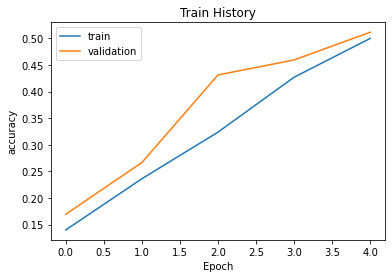

In [27]:
show_train_history(train_history,'accuracy','val_accuracy')#訓練的準確率比驗證的高->如果訓練的準確率一直增加，但是驗證的準確率卻沒有增加，則可能是overfitting

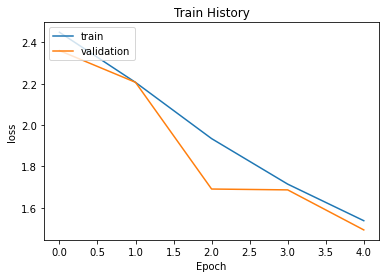

In [28]:
show_train_history(train_history,'loss','val_loss')#畫出誤差結果